## SVM
name: Yang Chen </br>

In this homework, we implement the SVM, logistic regression, and ensemble that combines the SVMs and decision trees.
1. We need to justify the choice of an appropriate number of epochs. There are several methods we can use.</br>
2. Report the result from the cross validation <\br>
3. compare the three

In [1]:
# first step we read the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def fileReader(file):
    # in total we have 123 features
    df = pd.read_csv(file, header=None, index_col=False)
    label = df[0]
    df.drop(columns=0, inplace=True)
    # here we extend the feature of the data with another column (1)
    # then we can include the b into the w
    df[207] = 1 # all three learning algorithms need the bias term
    df = df.to_numpy()
    label = label.to_numpy()
    return df, label

# prepare all datasets
train_features, train_label = fileReader("data 2/csv-format/train.csv")
test_features, test_label = fileReader("data 2/csv-format/test.csv")
cv1_features, cv1_label = fileReader("data 2/csv-format/CVfolds/fold1.csv")
cv2_features, cv2_label = fileReader("data 2/csv-format/CVfolds/fold2.csv")
cv3_features, cv3_label = fileReader("data 2/csv-format/CVfolds/fold3.csv")
cv4_features, cv4_label = fileReader("data 2/csv-format/CVfolds/fold4.csv")
cv5_features, cv5_label = fileReader("data 2/csv-format/CVfolds/fold5.csv")

# test the shape of each
print(train_features.shape, train_label.shape)
print(test_features.shape, test_label.shape)
print(cv1_features.shape, cv1_label.shape)
print(cv2_features.shape, cv2_label.shape)
print(cv3_features.shape, cv3_label.shape)
print(cv4_features.shape, cv4_label.shape)
print(cv5_features.shape, cv5_label.shape)

(2230, 207) (2230,)
(558, 207) (558,)
(446, 207) (446,)
(446, 207) (446,)
(446, 207) (446,)
(446, 207) (446,)
(446, 207) (446,)


In [2]:
# set up the random seed
np.random.seed(42)

In [45]:
# Part(1) Here we first implement the SVM with SGD.
# we define a SVM class with the functionality including train, predict

class SVM(object):

    def __init__(self):
        self.W = None # the container to store the weight vector

    # the train method
    def train(self, X, y, learning_rate, C, num_iters):
        # we still use the same
        num = X.shape[1]
        self.W = np.random.uniform(-0.01, 0.01, size=(num,))
        #self.W = np.zeros((num,))
        # history of list to store the loss at each iteration
        loss_his = []
        wrongs = []
        for it in range(num_iters):
            loss = 0
            wrong = 0
            # print("During the %d epoch!!" % (it+1))
            # shuffle the feature and label accordingly
            # use the shape[0] to shuffle these two arrays
            s = np.arange(X.shape[0]) # how many samples we have
            np.random.shuffle(s)
            shuffled_X = X[s]
            shuffled_y = y[s]
            # iterate through each sample
            for i, x in enumerate(shuffled_X):
                #print(x.shape)
                y_i = shuffled_y[i]
                if y_i*self.W @ x <= 1:
                    # add the loss
                    loss += 0.5*self.W @ self.W + C*(1-y_i*self.W @ x)
                    self.W = (1-learning_rate/(1+it))*self.W + (learning_rate/(1+it))*C*y_i*x
                else:
                    loss += 0.5*self.W @ self.W
                    self.W = (1-learning_rate/(1+it))*self.W
            # after this epoch we record the average loss
            avg_loss = loss/X.shape[0]
            loss_his.append(avg_loss)

            if it % 5 == 0:
                print('iteration %d / %d: loss: %f' % (it, num_iters, avg_loss))

        return loss_his

    # the predict method
    def predict(self, X):
        scores = X @ self.W
        mask = scores >= 0
        scores[mask] = 1
        scores[~mask] = -1
        return scores

    # get the accuracy
    def accuracy(self, y_pred, y):
        acc = np.sum(y_pred == y) / y.shape[0]
        return acc

iteration 0 / 30: loss: 1491508816.132938
iteration 5 / 30: loss: 106139800.964909
iteration 10 / 30: loss: 53070857.156795
iteration 15 / 30: loss: 37373294.322548
iteration 20 / 30: loss: 28256164.559078
iteration 25 / 30: loss: 22924841.904146
[-4.30210468e+01 -1.71517648e+02  2.94765519e+02  6.71017546e+01
 -2.83655683e+02 -2.41472272e+02 -2.52461842e+01  1.12792499e-10
 -7.24992704e+01 -1.78523521e+02  4.96887915e-03 -2.21921645e+02
 -1.44107559e+01  2.59303354e-03  2.58290283e+02 -2.32107636e+02
  2.91062140e+02  1.41019346e+01  4.10346369e+02  6.12923792e+02
 -6.69405554e-05  2.86269567e+02  1.37730025e+01 -7.21386320e+01
 -5.91157542e+01  4.23735833e+02  2.48905063e+02 -5.06125798e-03
  2.40556637e+02  1.78449189e+02  4.04356471e+02  4.25147401e-31
  1.03843829e-03 -3.86069314e+01  4.80084656e-01  8.22109537e-01
 -3.15797175e+02 -5.63650592e+01 -4.34142144e-06 -2.19801954e+00
 -2.15943858e+02  1.63844643e+02 -2.11400681e+02 -3.50106956e+01
 -7.31522854e+01  3.25221054e+02  6.56

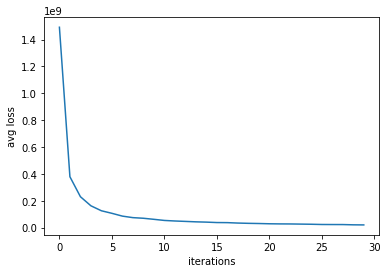

In [84]:
# to determine the number of epochs we use the smallest value of learning rate and C value, and try 50 epochs
svm = SVM()
train_loss_his = svm.train(train_features, train_label, 1, 10e3, 30)

plt.plot(train_loss_his)
plt.xlabel("iterations")
plt.ylabel("avg loss")
print(svm.W)

In [85]:
# we iterate through each depth and each fold as the validation set
learning_rates = [1, 0.1, 0.01, 10e-3, 10e-4]
Cs = [10e3, 10e2, 10, 1, 0.1, 0.01]
train_feature_folds = [cv1_features, cv2_features, cv3_features, cv4_features, cv5_features]
train_label_folds = [cv1_label, cv2_label, cv3_label, cv4_label, cv5_label]
num_of_folds = len(train_feature_folds)
accs = np.zeros([len(learning_rates)*len(Cs), num_of_folds])

for j,lr in enumerate(learning_rates):
    for k, C in enumerate(Cs):
        for i in range(num_of_folds):
            svm = SVM()
            print("We are doing the cross_validation on lr: %f, C: %f and the %d group as validation set!" % (lr, C, i+1))
            train_concat_features = np.concatenate([train_feature_folds[l] for l in range(num_of_folds) if l != i])
            train_concat_labels = np.concatenate([train_label_folds[l] for l in range(num_of_folds) if l != i])
            svm.train(train_concat_features, train_concat_labels, lr, C, 30)
            y_pred = svm.predict(train_feature_folds[i])
            acc = svm.accuracy(y_pred, train_label_folds[i])
            accs[j*6 + k][i] = acc

print("Finished!")

print(accs)
avg_accs = np.mean(accs, axis=1)
stds = np.std(accs, axis=1)
for i in range(len(learning_rates)):
    for j in range(len(Cs)):
        print("The average cross-validated accuracy with learning rate %f and C %f is %f" % (learning_rates[i], Cs[j], avg_accs[i*6+j]))
        print("The average cross-validated std with learning rate %f and C %f is %f" % (learning_rates[i], Cs[j], stds[i*6+j]))

We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 1 group as validation set!
iteration 0 / 30: loss: 1573661457.594479
iteration 5 / 30: loss: 103681426.311952
iteration 10 / 30: loss: 55692455.817516
iteration 15 / 30: loss: 38718850.390618
iteration 20 / 30: loss: 28199791.911232
iteration 25 / 30: loss: 23247576.463785
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 2 group as validation set!
iteration 0 / 30: loss: 1499586193.870979
iteration 5 / 30: loss: 106045103.457832
iteration 10 / 30: loss: 53078756.811111
iteration 15 / 30: loss: 37318531.222659
iteration 20 / 30: loss: 29101691.473057
iteration 25 / 30: loss: 21979075.937152
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 3 group as validation set!
iteration 0 / 30: loss: 1550174876.901619
iteration 5 / 30: loss: 106349082.143656
iteration 10 / 30: loss: 53921380.586017
iteration 15 / 30: loss: 36527601.874403
iteration 20 / 30: loss: 28536632.7

iteration 0 / 30: loss: 567928.148797
iteration 5 / 30: loss: 79014.347405
iteration 10 / 30: loss: 42248.287430
iteration 15 / 30: loss: 31136.897474
iteration 20 / 30: loss: 22872.152600
iteration 25 / 30: loss: 20267.813932
0.7497757847533633


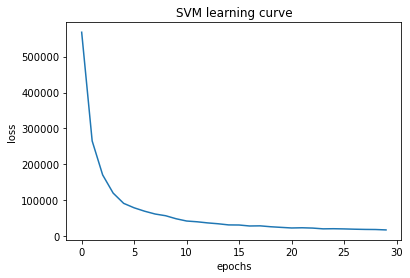

In [164]:
# step 2, train on the whole training set
svm = SVM()
train_loss = svm.train(train_features, train_label, 0.001, 10e3, 30)
y_pred = svm.predict(train_features)
acc = svm.accuracy(y_pred, train_label)
print(acc)
plt.plot(train_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("SVM learning curve")
plt.savefig("svm_loss.png", dpi=600)

In [53]:
# test on the test set
y_pred = svm.predict(test_features)
acc = svm.accuracy(y_pred, test_label)
print("the accuracy on the test set is %f." % acc)

the accuracy on the test set is 0.768817.


In [86]:
# implementation of Logistic regression
class LR(object):

    def __init__(self):
        self.W = None # the container to store the weight vector

    # the train method
    def train(self, X, y, learning_rate, tradeoff, num_iters):
        # we still use the same
        num = X.shape[1]
        self.W = np.random.uniform(-0.01, 0.01, size=(num,))
        #self.W = np.zeros((num,))
        # history of list to store the loss at each iteration
        loss_his = []
        for it in range(num_iters):
            loss = 0
            # print("During the %d epoch!!" % (it+1))
            # shuffle the feature and label accordingly
            # use the shape[0] to shuffle these two arrays
            s = np.arange(X.shape[0]) # how many samples we have
            np.random.shuffle(s)
            shuffled_X = X[s]
            shuffled_y = y[s]
            # iterate through each sample
            for i, x in enumerate(shuffled_X):
                #print(x.shape)
                y_i = shuffled_y[i]
                loss += np.log(1 + np.exp(-y_i*self.W @ x)+ (1/tradeoff)*self.W @ self.W)
                self.W = (1-(2*learning_rate/((1+it)*tradeoff)))*self.W + (learning_rate/(1+it))*(1 - self._sigma(x, y_i))*y_i*x
            # after this epoch we record the average loss
            avg_loss = loss/X.shape[0]
            loss_his.append(avg_loss)

            if it % 5 == 0:
                print('iteration %d / %d: loss: %f' % (it, num_iters, avg_loss))

        return loss_his

    # implement the sigma
    def _sigma(self, x, y):
        value = y*self.W @ x
        if  value < 0:
            return np.exp(value) / (1 + np.exp(value))
        else:
            return 1 / (1 + np.exp(-value))

    # the predict method (no need to change this part!)
    def predict(self, X):
        scores = X @ self.W
        mask = scores >= 0
        scores[mask] = 1
        scores[~mask] = -1
        return scores

    # get the accuracy
    def accuracy(self, y_pred, y):
        acc = np.sum(y_pred == y) / y.shape[0]
        return acc

iteration 0 / 20: loss: 4.767070
iteration 5 / 20: loss: 0.789402
iteration 10 / 20: loss: 0.551962
iteration 15 / 20: loss: 0.471061


Text(0, 0.5, 'avg loss')

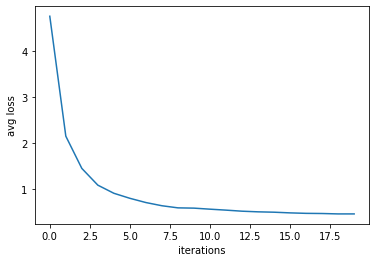

In [87]:
# to determine the number of epochs we use the smallest value of learning rate and tradeoff
lr = LR()
train_loss_his = lr.train(train_features, train_label, 1, 10e3, 20)

plt.plot(train_loss_his)
plt.xlabel("iterations")
plt.ylabel("avg loss")

In [88]:
# we iterate through each depth and each fold as the validation set
learning_rates = [1, 0.1, 0.01, 10e-3, 10e-4, 10e-5]
Cs = [10e-1, 1, 10, 100, 10e3, 10e4]
train_feature_folds = [cv1_features, cv2_features, cv3_features, cv4_features, cv5_features]
train_label_folds = [cv1_label, cv2_label, cv3_label, cv4_label, cv5_label]
num_of_folds = len(train_feature_folds)
accs = np.zeros([len(learning_rates)*len(Cs), num_of_folds])

for j,lr in enumerate(learning_rates):
    for k, tf in enumerate(Cs):
        for i in range(num_of_folds):
            lgr = LR()
            print("We are doing the cross_validation on lr: %f, tradeoff: %f and the %d group as validation set!" % (lr, tf, i+1))
            train_concat_features = np.concatenate([train_feature_folds[l] for l in range(num_of_folds) if l != i])
            train_concat_labels = np.concatenate([train_label_folds[l] for l in range(num_of_folds) if l != i])
            lgr.train(train_concat_features, train_concat_labels, lr, tf, 20)
            y_pred = lgr.predict(train_feature_folds[i])
            acc = lgr.accuracy(y_pred, train_label_folds[i])
            accs[j*6 + k][i] = acc

print("Finished!")

print(accs)
avg_accs = np.mean(accs, axis=1)
stds = np.std(accs, axis=1)
for i in range(len(learning_rates)):
    for j in range(len(Cs)):
        print("The average cross-validated accuracy with learning rate %f and C %f is %f" % (learning_rates[i], Cs[j], avg_accs[i*6+j]))
        print("The average cross-validated std with learning rate %f and C %f is %f" % (learning_rates[i], Cs[j], stds[i*6+j]))


We are doing the cross_validation on lr: 1.000000, tradeoff: 1.000000 and the 1 group as validation set!
iteration 0 / 20: loss: inf
iteration 5 / 20: loss: 1.023212
iteration 10 / 20: loss: 0.840623
iteration 15 / 20: loss: 0.794149
We are doing the cross_validation on lr: 1.000000, tradeoff: 1.000000 and the 2 group as validation set!
iteration 0 / 20: loss: inf
iteration 5 / 20: loss: 1.043548
iteration 10 / 20: loss: 0.841850
iteration 15 / 20: loss: 0.784314
We are doing the cross_validation on lr: 1.000000, tradeoff: 1.000000 and the 3 group as validation set!
iteration 0 / 20: loss: inf
iteration 5 / 20: loss: 1.044248
iteration 10 / 20: loss: 0.841794
iteration 15 / 20: loss: 0.793593
We are doing the cross_validation on lr: 1.000000, tradeoff: 1.000000 and the 4 group as validation set!
iteration 0 / 20: loss: inf
iteration 5 / 20: loss: 1.031433
iteration 10 / 20: loss: 0.842712
iteration 15 / 20: loss: 0.792880
We are doing the cross_validation on lr: 1.000000, tradeoff: 1.0

<ipython-input-86-c01d69bf4c9f>:28: RuntimeWarning: overflow encountered in exp
  loss += np.log(1 + np.exp(-y_i*self.W @ x)+ (1/tradeoff)*self.W @ self.W)


iteration 0 / 20: loss: 0.703654
iteration 5 / 20: loss: 0.414871
iteration 10 / 20: loss: 0.397905
iteration 15 / 20: loss: 0.391393
0.8358744394618834


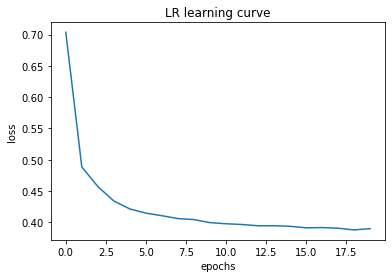

In [163]:
lgr = LR()
train_loss = lgr.train(train_features, train_label, 0.1, 10e3, 20)
y_pred = lgr.predict(train_features)
acc = lgr.accuracy(y_pred, train_label)
print(acc)
plt.plot(train_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LR learning curve")
plt.savefig("lr_loss.png", dpi=600)

In [91]:
# test on the test set
y_pred = lgr.predict(test_features)
acc = lgr.accuracy(y_pred, test_label)
print("the accuracy on the test set is %f." % acc)

the accuracy on the test set is 0.788530.


In [110]:
# implement the SVM over trees
# we first get the ID3_pruned algorithm
class Node:
    # we define the node data structure to store feature, left node, right node, label
    # if it is a feature node, then label should be None
    # if it is a label node, the feature should be None
    def __init__(self):
        self.feature = None # choose from the feature list [1, 2, ... , 123]
        # self.left = None
        # self.right = None
        # generalize this for more values for later use
        # because, there is possibility that we have more that binary values
        self.children = {}
        self.label = None # can only from [-1, 1] from the label set

def is_unique(label_data):
    """
    :param label_data:
    :return: boolean whether the label dataset has the same value
    """
    label_array = label_data.to_numpy()
    return (label_array[0] == label_array).all()

def entropy(label_data):
    """
    :param label_data:
    :return: information entropy of corresponding labels under certain condition
    """
    labels = label_data.value_counts().to_list()
    entropy = np.sum([(-labels[i]/len(label_data)*np.log2(labels[i]/len(label_data))) for i in range(len(labels))])
    return entropy

def InfoGain(feature_data, label_data, feature, total_entropy):
    # find out what attribute can this feature take
    # in this case, values can only be 0 or 1
    # but later for generalization, values can take more than two values
    values = feature_data[feature].value_counts().index.to_list()
    weighted_entropy = np.sum([len(feature_data[feature_data[feature] == value])/len(feature_data) * entropy(label_data[feature_data[feature] == value]) for value in values])
    return total_entropy - weighted_entropy

def most_common(label_data):
    return label_data.value_counts().idxmax()

def accuracy(trained_tree, test_features, test_label):
    """
    Parameters:
        trained_tree: A train tree
        test_features: the dataset of test feature
        test_label: the dataset of test label
    Returns:
        accuracy
    """
    # convert the dataframe to ndarray
    test_features = test_features.to_numpy()
    test_label = test_label.to_numpy()
    N = test_features.shape[0]
    print(N)

    # Set the counter to 0
    num_of_correct_predictions = 0

    for i in range(N):
        if predict(trained_tree, test_features[i]) == test_label[i]:
            num_of_correct_predictions += 1

    return num_of_correct_predictions / N


def predict(node, test_instance):
    """
    Parameters:
        node: A trained tree node
        test_instance: A single test instance
    Returns:
        predicted label
    """
    # Boundary Condition
    if len(node.children) == 0:
        return node.label
    else:
        # get corresponding value
        # value = test_instance[int(node.feature)]
        # value = test_instance[int(node.feature) - 1]
        value = test_instance[node.feature]
        # Follow the tree to get the corresponding label of the test instance
        if value in node.children.keys():
            # Recursive call
            return predict(node.children[value], test_instance)

In [111]:
def ID3_pruned(feature_data, label_data, features, default, depth, level = 0):

    # the most commom feature from the previous dataset
    # if there is no data but still features
    if len(label_data) == 0:
        tree_node = Node()
        tree_node.label = default
        return tree_node
    # first deal with the boundary conditions
    # boundary condition 1: if the label has the same value
    if is_unique(label_data):
        # we assign the label to the tree node as a label node and return
        tree_node = Node()
        tree_node.label = label_data.value_counts().idxmax()
        return tree_node

    # boundary condition 2: if the features set is empty
    # or the tree level equals to the hyperparameter depth
    # if features is empty, it will return False in the if statement
    if (not features) or (level == depth): # True if the feature list is empty
        # find the most common label in and return as label node
        most_common_label = label_data.value_counts().idxmax()
        tree_node = Node()
        tree_node.label = most_common_label
        return tree_node
    else: # the normal case when the features list is not empty
        # find the feature for the current tree node
        # the information entropy of the current data set
        total_entropy = entropy(label_data)
        # we find the best feature for this tree node
        info_gains = [InfoGain(feature_data, label_data, feature, total_entropy) for feature in features]
        best_feature_index = np.argmax(info_gains)
        # print("the largest info gain is %f " % np.max(info_gains))
        best_feature = features[best_feature_index]
        tree_node = Node()
        # create a feature tree node
        tree_node.feature = best_feature
        tree_node.label = None

        # update the data set and feature set
        features = [i for i in features if i != best_feature]
        for value in feature_data[best_feature].value_counts().index.to_list():
            # print(value)
            new_feature_data = feature_data[feature_data[best_feature] == value]
            new_feature_data.drop(columns=best_feature)
            new_label_data = label_data[feature_data[best_feature] == value]
            # if best_feature == "40":
            #    print(tree_node.feature, value, new_label_data.value_counts())
            #    print(features)
            sub_tree = ID3_pruned(new_feature_data, new_label_data, features, most_common(feature_data), depth, level+1)
            # put the corresponding reuturn tree into the node
            tree_node.children[value] = sub_tree

        return tree_node

In [114]:
# modify the data
def fileReader2(file):
    # in total we have 123 features
    df = pd.read_csv(file, header=None, index_col=False)
    label = df[0]
    df.drop(columns=0, inplace=True)
    return df, label

# prepare all datasets
df_train_features, df_train_label = fileReader2("data 2/csv-format/train.csv")
df_test_features, df_test_label = fileReader2("data 2/csv-format/test.csv")
df_cv1_features, df_cv1_label = fileReader2("data 2/csv-format/CVfolds/fold1.csv")
df_cv2_features, df_cv2_label = fileReader2("data 2/csv-format/CVfolds/fold2.csv")
df_cv3_features, df_cv3_label = fileReader2("data 2/csv-format/CVfolds/fold3.csv")
df_cv4_features, df_cv4_label = fileReader2("data 2/csv-format/CVfolds/fold4.csv")
df_cv5_features, df_cv5_label = fileReader2("data 2/csv-format/CVfolds/fold5.csv")

# test the shape of each
print(df_train_features.shape, df_train_label.shape)
print(df_test_features.shape, df_test_label.shape)
print(df_cv1_features.shape, df_cv1_label.shape)
print(df_cv2_features.shape, df_cv2_label.shape)
print(df_cv3_features.shape, df_cv3_label.shape)
print(df_cv4_features.shape, df_cv4_label.shape)
print(df_cv5_features.shape, df_cv5_label.shape)

print(df_train_features.head())

(2230, 206) (2230,)
(558, 206) (558,)
(446, 206) (446,)
(446, 206) (446,)
(446, 206) (446,)
(446, 206) (446,)
(446, 206) (446,)
   1    2    3    4    5    6    7    8    9    10   ...  197  198  199  200  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  1.0  1.0   
2  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  1.0  0.0  0.0   

   201  202  203  204  205  206  
0  1.0  1.0  1.0  1.0  0.0  1.0  
1  1.0  0.0  1.0  1.0  1.0  0.0  
2  1.0  1.0  1.0  1.0  1.0  0.0  
3  1.0  1.0  1.0  1.0  0.0  1.0  
4  0.0  0.0  1.0  0.0  1.0  0.0  

[5 rows x 206 columns]


In [116]:
features = [i for i in range(1, 207)]
trees_1, trees_2, trees_4, trees_8= [], [], [], []
trees = [trees_1, trees_2, trees_4, trees_8]
depths = [1,2,4,8]
for i, depth in enumerate(depths):
    print("Traing with depth %d " % depth)
    for _ in range(200):
        # prepare the data
        sample_X = df_train_features.sample(frac=0.1, replace=True, random_state=1)
        sample_y = df_train_label.sample(frac=0.1, replace=True, random_state=1)
        tree = ID3_pruned(sample_X, sample_y, features, most_common(sample_y), depth=depth)
        trees[i].append(tree)
    print("finish depth %d" % depth)


Traing with depth 1 
finish depth 1
Traing with depth 2 
finish depth 2
Traing with depth 4 
finish depth 4
Traing with depth 8 
finish depth 8


In [143]:
# define the function to transform all data based on the trees
def transform(data, trees):
    data = data.to_numpy()
    N = data.shape[0]
    transform_1, transform_2, transform_4, transform_8 = [], [], [], []
    transformed = [transform_1, transform_2, transform_4, transform_8]
    for i, tree in enumerate(trees):
        print("doing the the %d group of tree" % (i+1))
        for j in range(N):
            trans_features = []
            for t in tree:
                trans_features.append(predict(t, data[j]))
            trans_features.append(1)
            # print("the length of transformed feature %d " % len(trans_features))# to make sure the bias term for SVM
            transformed[i].append(trans_features)
        transformed[i] = np.array(transformed[i])
        print("finish the % group of tree" % (i+1))
    return transformed

In [144]:
transformed_train_features = transform(df_train_features, trees)
transformed_test_features = transform(df_test_features, trees)
transformed_cv1_features = transform(df_cv1_features, trees)
transformed_cv2_features = transform(df_cv2_features, trees)
transformed_cv3_features = transform(df_cv3_features, trees)
transformed_cv4_features = transform(df_cv4_features, trees)
transformed_cv5_features = transform(df_cv5_features, trees)

doing the the 1 group of tree
finish the  1roup of tree
doing the the 2 group of tree
finish the  2roup of tree
doing the the 3 group of tree
finish the  3roup of tree
doing the the 4 group of tree
finish the  4roup of tree
doing the the 1 group of tree
finish the  1roup of tree
doing the the 2 group of tree
finish the  2roup of tree
doing the the 3 group of tree
finish the  3roup of tree
doing the the 4 group of tree
finish the  4roup of tree
doing the the 1 group of tree
finish the  1roup of tree
doing the the 2 group of tree
finish the  2roup of tree
doing the the 3 group of tree
finish the  3roup of tree
doing the the 4 group of tree
finish the  4roup of tree
doing the the 1 group of tree
finish the  1roup of tree
doing the the 2 group of tree
finish the  2roup of tree
doing the the 3 group of tree
finish the  3roup of tree
doing the the 4 group of tree
finish the  4roup of tree
doing the the 1 group of tree
finish the  1roup of tree
doing the the 2 group of tree
finish the  2roup 

In [145]:
for data in transformed_cv1_features:
    print(data.shape)

(446, 201)
(446, 201)
(446, 201)
(446, 201)


In [146]:
# we do the cross validation for each depth case
# we iterate through each depth and each fold as the validation set
learning_rates = [1, 0.1, 0.01, 10e-3, 10e-4, 10e-5]
Cs = [10e3, 10e2, 10, 1, 0.1, 0.01]
# prepare the dataset
train_feature_folds = [transformed_cv1_features, transformed_cv2_features, transformed_cv3_features, transformed_cv4_features, transformed_cv5_features]
trans_d1_folds = [data[0] for data in train_feature_folds]
trans_d2_folds = [data[1] for data in train_feature_folds]
trans_d4_folds = [data[2] for data in train_feature_folds]
trans_d8_folds = [data[3] for data in train_feature_folds]
train_label_folds = [cv1_label, cv2_label, cv3_label, cv4_label, cv5_label]

accs1 = np.zeros([len(learning_rates)*len(Cs), 5])
accs2 = np.zeros([len(learning_rates)*len(Cs), 5])
accs4 = np.zeros([len(learning_rates)*len(Cs), 5])
accs8 = np.zeros([len(learning_rates)*len(Cs), 5])

In [154]:
# deal with the depth 1
for j,lr in enumerate(learning_rates):
    for k, C in enumerate(Cs):
        for i in range(5):
            svm = SVM()
            print("We are doing the cross_validation on lr: %f, C: %f and the %d group as validation set!" % (lr, C, i+1))
            train_concat_features = np.concatenate([trans_d1_folds[l] for l in range(5) if l != i])
            train_concat_labels = np.concatenate([train_label_folds[l] for l in range(5) if l != i])
            svm.train(train_concat_features, train_concat_labels, lr, C, 30)
            y_pred = svm.predict(trans_d1_folds[i])
            acc = svm.accuracy(y_pred, train_label_folds[i])
            accs1[j*6 + k][i] = acc

print("Finished!")

print(accs1)
avg_accs = np.mean(accs1, axis=1)
stds = np.std(accs1, axis=1)
arg = np.argmax(avg_accs)
lr_index = arg // 6
C_index = arg % 6
print("The max accuracy is %f and the lr is %f and C is %f." % (np.max(avg_accs), learning_rates[lr_index], Cs[C_index]))

We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 1 group as validation set!
iteration 0 / 30: loss: 13281480863.406338
iteration 5 / 30: loss: 911599206.648565
iteration 10 / 30: loss: 481458304.750900
iteration 15 / 30: loss: 328182968.876403
iteration 20 / 30: loss: 244404798.259079
iteration 25 / 30: loss: 195971086.617088
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 2 group as validation set!
iteration 0 / 30: loss: 13618812769.521296
iteration 5 / 30: loss: 897497213.266659
iteration 10 / 30: loss: 478686943.142739
iteration 15 / 30: loss: 317924973.948951
iteration 20 / 30: loss: 242192070.932101
iteration 25 / 30: loss: 200846513.642239
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 3 group as validation set!
iteration 0 / 30: loss: 13466150179.487118
iteration 5 / 30: loss: 929576061.790043
iteration 10 / 30: loss: 472337964.896336
iteration 15 / 30: loss: 315662496.955633
iteration 20 / 30: los

In [155]:
# deal with the depth 2
for j,lr in enumerate(learning_rates):
    for k, C in enumerate(Cs):
        for i in range(5):
            svm = SVM()
            print("We are doing the cross_validation on lr: %f, C: %f and the %d group as validation set!" % (lr, C, i+1))
            train_concat_features = np.concatenate([trans_d2_folds[l] for l in range(5) if l != i])
            train_concat_labels = np.concatenate([train_label_folds[l] for l in range(5) if l != i])
            svm.train(train_concat_features, train_concat_labels, lr, C, 30)
            y_pred = svm.predict(trans_d2_folds[i])
            acc = svm.accuracy(y_pred, train_label_folds[i])
            accs2[j*6 + k][i] = acc

print("Finished!")

print(accs2)
avg_accs = np.mean(accs2, axis=1)
stds = np.std(accs2, axis=1)
arg = np.argmax(avg_accs)
lr_index = arg // 6
C_index = arg % 6
print("The max accuracy is %f and the lr is %f and C is %f." % (np.max(avg_accs), learning_rates[lr_index], Cs[C_index]))

We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 1 group as validation set!
iteration 0 / 30: loss: 12647287909.964312
iteration 5 / 30: loss: 891608416.013337
iteration 10 / 30: loss: 472601928.453252
iteration 15 / 30: loss: 305559353.720559
iteration 20 / 30: loss: 235346066.630949
iteration 25 / 30: loss: 196707955.065722
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 2 group as validation set!
iteration 0 / 30: loss: 13462899058.514675
iteration 5 / 30: loss: 877884515.463969
iteration 10 / 30: loss: 495659070.462383
iteration 15 / 30: loss: 314877146.772762
iteration 20 / 30: loss: 230204829.689419
iteration 25 / 30: loss: 189524165.015906
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 3 group as validation set!
iteration 0 / 30: loss: 13152501014.253338
iteration 5 / 30: loss: 929342510.468112
iteration 10 / 30: loss: 469842682.011414
iteration 15 / 30: loss: 325314536.764628
iteration 20 / 30: los

In [156]:
# deal with the depth 4
for j,lr in enumerate(learning_rates):
    for k, C in enumerate(Cs):
        for i in range(5):
            svm = SVM()
            print("We are doing the cross_validation on lr: %f, C: %f and the %d group as validation set!" % (lr, C, i+1))
            train_concat_features = np.concatenate([trans_d4_folds[l] for l in range(5) if l != i])
            train_concat_labels = np.concatenate([train_label_folds[l] for l in range(5) if l != i])
            svm.train(train_concat_features, train_concat_labels, lr, C, 30)
            y_pred = svm.predict(trans_d4_folds[i])
            acc = svm.accuracy(y_pred, train_label_folds[i])
            accs4[j*6 + k][i] = acc

print("Finished!")

print(accs4)
avg_accs = np.mean(accs4, axis=1)
stds = np.std(accs4, axis=1)
arg = np.argmax(avg_accs)
lr_index = arg // 6
C_index = arg % 6
print("The max accuracy is %f and the lr is %f and C is %f." % (np.max(avg_accs), learning_rates[lr_index], Cs[C_index]))

We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 1 group as validation set!
iteration 0 / 30: loss: 13180555952.329758
iteration 5 / 30: loss: 923726731.130738
iteration 10 / 30: loss: 447955541.441170
iteration 15 / 30: loss: 308274093.381127
iteration 20 / 30: loss: 236692985.450581
iteration 25 / 30: loss: 194004662.792930
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 2 group as validation set!
iteration 0 / 30: loss: 13050090683.132082
iteration 5 / 30: loss: 877766956.945479
iteration 10 / 30: loss: 443886111.995167
iteration 15 / 30: loss: 313207699.184780
iteration 20 / 30: loss: 232551573.893300
iteration 25 / 30: loss: 184645575.095090
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 3 group as validation set!
iteration 0 / 30: loss: 13387871019.293015
iteration 5 / 30: loss: 913061080.141685
iteration 10 / 30: loss: 470052167.368172
iteration 15 / 30: loss: 317689394.258798
iteration 20 / 30: los

In [157]:
print(accs4)

[[0.43273543 0.6367713  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.6367713  0.59641256 0.58744395 0.42825112]
 [0.43273543 0.6367713  0.40358744 0.58744395 0.57174888]
 [0.43273543 0.3632287  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.3632287  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.6367713  0.59641256 0.58744395 0.57174888]
 [0.43273543 0.3632287  0.40358744 0.41255605 0.57174888]
 [0.56726457 0.3632287  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.3632287  0.40358744 0.41255605 0.42825112]
 [0.56726457 0.6367713  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.6367713  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.6367713  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.47533632 0.59641256 0.58744395 0.57174888]
 [0.56726457 0.6367713  0.59641256 0.51345291 0.57174888]
 [0.5470852  0.6367713  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.6367713  0.59641256 0.58744395 0.57174888]
 [0.56726457 0.6367713  0.59641256 0.58744395 0.57174888]
 [0.56726457 0

In [158]:
# deal with the depth 8
for j,lr in enumerate(learning_rates):
    for k, C in enumerate(Cs):
        for i in range(5):
            svm = SVM()
            print("We are doing the cross_validation on lr: %f, C: %f and the %d group as validation set!" % (lr, C, i+1))
            train_concat_features = np.concatenate([trans_d8_folds[l] for l in range(5) if l != i])
            train_concat_labels = np.concatenate([train_label_folds[l] for l in range(5) if l != i])
            svm.train(train_concat_features, train_concat_labels, lr, C, 30)
            y_pred = svm.predict(trans_d8_folds[i])
            acc = svm.accuracy(y_pred, train_label_folds[i])
            accs8[j*6 + k][i] = acc

print("Finished!")

print(accs8)
avg_accs = np.mean(accs8, axis=1)
stds = np.std(accs8, axis=1)
arg = np.argmax(avg_accs)
lr_index = arg // 6
C_index = arg % 6
print("The max accuracy is %f and the lr is %f and C is %f." % (np.max(avg_accs), learning_rates[lr_index], Cs[C_index]))

We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 1 group as validation set!
iteration 0 / 30: loss: 12422456031.726767
iteration 5 / 30: loss: 873831213.549357
iteration 10 / 30: loss: 442882045.579774
iteration 15 / 30: loss: 299519074.898716
iteration 20 / 30: loss: 227493115.326263
iteration 25 / 30: loss: 178304549.947445
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 2 group as validation set!
iteration 0 / 30: loss: 13025483054.836708
iteration 5 / 30: loss: 855316375.246642
iteration 10 / 30: loss: 449160129.865334
iteration 15 / 30: loss: 314390112.850943
iteration 20 / 30: loss: 230474876.843995
iteration 25 / 30: loss: 178427878.525737
We are doing the cross_validation on lr: 1.000000, C: 10000.000000 and the 3 group as validation set!
iteration 0 / 30: loss: 12409059165.045872
iteration 5 / 30: loss: 827748156.342130
iteration 10 / 30: loss: 450337722.805106
iteration 15 / 30: loss: 304555690.249396
iteration 20 / 30: los

iteration 0 / 30: loss: 128495948.000354
iteration 5 / 30: loss: 8307517.660516
iteration 10 / 30: loss: 4633099.336541
iteration 15 / 30: loss: 2931206.416646
iteration 20 / 30: loss: 2329630.685092
iteration 25 / 30: loss: 1778921.967677
0.6246636771300449


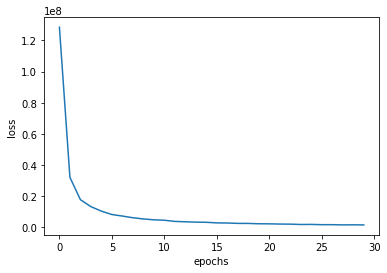

In [161]:
svm = SVM()
loss_hist = svm.train(transformed_train_features[3], train_label, 1, 1000, 30)
y_pred = svm.predict(transformed_train_features[3])
acc = svm.accuracy(y_pred, train_label)
print(acc)
plt.plot(loss_hist)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.savefig("svm_over_tree.png", dpi=600)

In [162]:
# on the test set
y_pred = svm.predict(transformed_test_features[3])
acc = svm.accuracy(y_pred, test_label)
print(acc)


0.6236559139784946
